In [100]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dataclasses import dataclass
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import display, clear_output

In [2]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

                # Use this two lines if you want to visualize the weights
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            
            # Use this two lines if you want to visualize the weights
            # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]


In [3]:
class Model(nn.Module):

    # FITS: Frequency Interpolation Time Series Forecasting

    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.individual = configs.individual
        self.channels = configs.enc_in

        self.dominance_freq=configs.cut_freq # 720/24
        self.length_ratio = (self.seq_len + self.pred_len)/self.seq_len

        if self.individual:
            self.freq_upsampler = nn.ModuleList()
            for i in range(self.channels):
                self.freq_upsampler.append(nn.Linear(self.dominance_freq, int(self.dominance_freq*self.length_ratio)).to(torch.cfloat))

        else:
            self.freq_upsampler = nn.Linear(self.dominance_freq, int(self.dominance_freq*self.length_ratio)).to(torch.cfloat) # complex layer for frequency upcampling]
        # configs.pred_len=configs.seq_len+configs.pred_len
        # #self.Dlinear=DLinear.Model(configs)
        # configs.pred_len=self.pred_len


    def forward(self, x):
        # RIN
        x_mean = torch.mean(x, dim=1, keepdim=True)
        x = x - x_mean
        x_var=torch.var(x, dim=1, keepdim=True)+ 1e-5
        # print(x_var)
        x = x / torch.sqrt(x_var)

        low_specx = torch.fft.rfft(x, dim=1)
        low_specx[:,self.dominance_freq:]=0 # LPF
        low_specx = low_specx[:,0:self.dominance_freq,:] # LPF
        # print(low_specx.permute(0,2,1))
        if self.individual:
            low_specxy_ = torch.zeros([low_specx.size(0),int(self.dominance_freq*self.length_ratio),low_specx.size(2)],dtype=low_specx.dtype).to(low_specx.device)
            for i in range(self.channels):
                low_specxy_[:,:,i]=self.freq_upsampler[i](low_specx[:,:,i].permute(0,1)).permute(0,1)
        else:
            low_specxy_ = self.freq_upsampler(low_specx.permute(0,2,1)).permute(0,2,1)
        # print(low_specxy_)
        low_specxy = torch.zeros([low_specxy_.size(0),int((self.seq_len+self.pred_len)/2+1),low_specxy_.size(2)],dtype=low_specxy_.dtype).to(low_specxy_.device)
        low_specxy[:,0:low_specxy_.size(1),:]=low_specxy_ # zero padding
        low_xy=torch.fft.irfft(low_specxy, dim=1)
        low_xy=low_xy * self.length_ratio # compemsate the length change
        # dom_x=x-low_x
        
        # dom_xy=self.Dlinear(dom_x)
        # xy=(low_xy+dom_xy) * torch.sqrt(x_var) +x_mean # REVERSE RIN
        xy=(low_xy) * torch.sqrt(x_var) +x_mean
        return xy, low_xy* torch.sqrt(x_var)



In [81]:
@dataclass
class Config:
    seq_len: int = 240
    pred_len: int = 120
    individual: bool = False
    enc_in: int = 1
    cut_freq: int = 20

model=Model(Config())
for param in model.parameters():
    param.data.fill_(0)

In [82]:
model_optim=optim.Adam(model.parameters(),lr=1e-4)
criterion=nn.MSELoss()

In [89]:
import yfinance as yf
data = yf.download("SPY AAPL", period="4000d", interval="1d")

[*********************100%%**********************]  2 of 2 completed


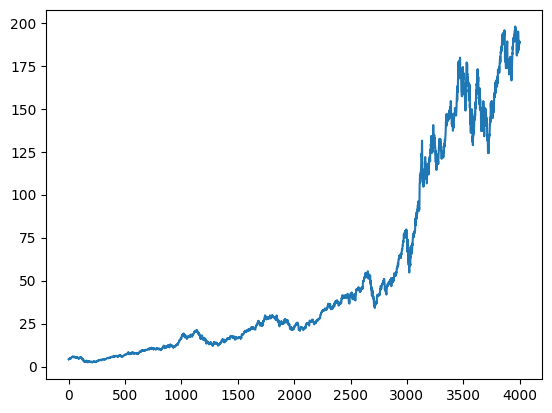

In [90]:
y = data["Adj Close"]["AAPL"].values
y = y[:4000]
plt.plot(y)

In [69]:
for epoch in range(1000): # train 1000 epochs
    order=np.random.permutation(2000) # shuffle the training sample
    train_loss=[]
    for batch in range(25): # split each epoch into 25 batches
        batch_start=order[batch*80:(batch+1)*80] # each batch has 80 samples
        batch=[]
        for i in batch_start:
            batch.append(y[i:i+240+120])
        batch_xy=np.array(batch).reshape(80,360,1) # 80 batch_size, 360 time steps, 1 feature

        batch_xy=torch.from_numpy(batch_xy).float()#.to('mps')

        batch_x=batch_xy[:,:240,:]
        batch_y=batch_xy[:,240:,:]

        model_optim.zero_grad()

        output,low=model(batch_x)

        # output=output[:,-120:,:]

        loss=criterion(output,batch_xy) # supervise on xy (only supervise on y also achieve the same result)

        train_loss.append(loss.item())

        loss.backward()

        model_optim.step()

    print('epoch: ',epoch,' loss: ',np.mean(train_loss))

epoch:  0  loss:  0.8400666189193725
epoch:  1  loss:  0.8400678730010986
epoch:  2  loss:  0.8400507688522338
epoch:  3  loss:  0.8400570821762084
epoch:  4  loss:  0.8400486588478089
epoch:  5  loss:  0.8400543308258057
epoch:  6  loss:  0.840058434009552
epoch:  7  loss:  0.8400573611259461
epoch:  8  loss:  0.8400494360923767
epoch:  9  loss:  0.8400642657279969
epoch:  10  loss:  0.8400715231895447
epoch:  11  loss:  0.8400593757629394
epoch:  12  loss:  0.8400483274459839
epoch:  13  loss:  0.8400833582878113
epoch:  14  loss:  0.8400570821762084
epoch:  15  loss:  0.8400398659706115
epoch:  16  loss:  0.8400442099571228
epoch:  17  loss:  0.8400555372238159
epoch:  18  loss:  0.8400527882575989
epoch:  19  loss:  0.8400726389884948
epoch:  20  loss:  0.8400403094291687
epoch:  21  loss:  0.8400335788726807
epoch:  22  loss:  0.8400592088699341
epoch:  23  loss:  0.8400448417663574
epoch:  24  loss:  0.8400569868087768
epoch:  25  loss:  0.8400464344024658
epoch:  26  loss:  0.84

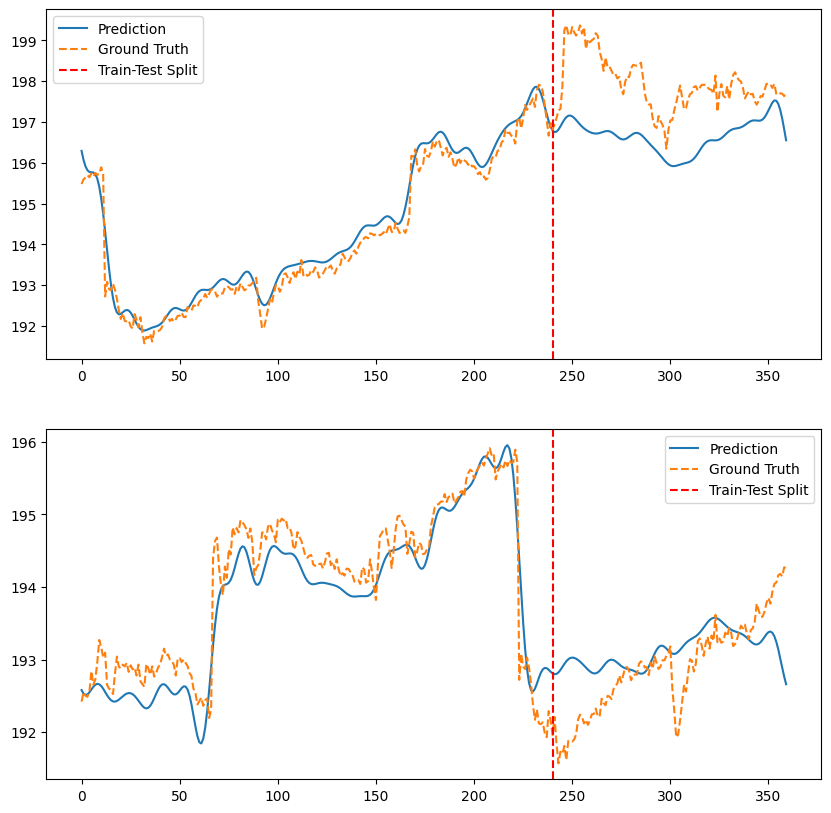

In [70]:
output=output.cpu().detach().numpy()
batch_xy=batch_xy.cpu().detach().numpy()


plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(output[0,:,0], label="Prediction")
plt.plot(batch_xy[0,:,0],'--', label="Ground Truth")
plt.axvline(240, color='r', linestyle='--', label="Train-Test Split")
plt.legend()
plt.subplot(2,1,2)
plt.plot(output[2,:,0], label="Prediction")
plt.plot(batch_xy[2,:,0], '--', label="Ground Truth")
plt.axvline(240, color='r', linestyle='--', label="Train-Test Split")
plt.legend()
plt.show()

In [65]:
def train_time_series(y, total_samples=4000, batch_size=80, train_split=0.8, epochs=1000):
    # Calculate split sizes for train and test
    num_train_samples = int(total_samples * train_split)
    
    # Assuming `y` is your dataset with time series data
    # Make sure `y` has at least `total_samples + 360` samples to avoid index out of bounds
    assert len(y) >= total_samples + 360, "Dataset `y` is too small for the given total_samples and lookahead."
    
    for epoch in range(epochs):
        # Shuffle the training sample indices
        order = np.random.permutation(num_train_samples)
        
        train_loss = []
        num_batches = num_train_samples // batch_size  # Calculate number of batches
        
        for batch in range(num_batches):
            batch_start = order[batch * batch_size:(batch + 1) * batch_size]
            batch_data = []
            for i in batch_start:
                batch_data.append(y[i:i+240+120])
            batch_xy = np.array(batch_data).reshape(batch_size, 360, 1)  # Reshape for batch_size, time steps, feature

            # Convert to PyTorch tensors
            batch_xy = torch.from_numpy(batch_xy).float()  # Consider specifying device here, if needed
            
            # Split into inputs and targets
            batch_x = batch_xy[:, :240, :]
            batch_y = batch_xy[:, 240:, :]

            model_optim.zero_grad()

            # Forward pass
            output, _ = model(batch_x)
            print(output.shape, batch_y.shape)
            loss = criterion(output, batch_y)
            loss.backward()
            model_optim.step()
            train_loss.append(loss.item())

        # Logging
        print(f'Epoch: {epoch}, Loss: {np.mean(train_loss)}')

In [66]:
train_time_series(y, total_samples=2000, batch_size=80, train_split=0.8, epochs=1000)

torch.Size([80, 360, 1]) torch.Size([80, 120, 1])


/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([80, 120, 1])) that is different to the input size (torch.Size([80, 360, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (360) must match the size of tensor b (120) at non-singleton dimension 1

In [158]:
seq_len = 340
pred_len = 120
total_len = seq_len + pred_len
@dataclass
class Config:
    seq_len: int = seq_len
    pred_len: int = pred_len
    individual: bool = False
    enc_in: int = 1
    cut_freq: int = 50

model=Model(Config())
for param in model.parameters():
    param.data.fill_(0)

model_optim=optim.Adam(model.parameters(),lr=1e-4)
criterion=nn.MSELoss()

In [159]:
for epoch in tqdm(range(1000), desc='Training Progress'):
    order = np.random.permutation(2000)
    train_loss = []
    for batch in range(25):
        batch_start = order[batch*80:(batch+1)*80]
        batch = []
        for i in batch_start:
            batch.append(y[i:i+total_len])
        batch_xy = np.array(batch).reshape(80, total_len, 1)
        batch_xy = torch.from_numpy(batch_xy).float()

        batch_x = batch_xy[:, :seq_len, :]
        batch_y = batch_xy[:, seq_len:, :]

        model_optim.zero_grad()

        output, _ = model(batch_x)

        loss = criterion(output, batch_xy)

        train_loss.append(loss.item())

        loss.backward()

        model_optim.step()

    clear_output(wait=True)
    display(f'Epoch: {epoch} Loss: {np.mean(train_loss)}')

clear_output(wait=True)
display(f'Final Epoch: {epoch} Loss: {np.mean(train_loss)}')

'Final Epoch: 999 Loss: 1.6312011098861694'

In [160]:
output=output.cpu().detach().numpy()
batch_xy=batch_xy.cpu().detach().numpy()

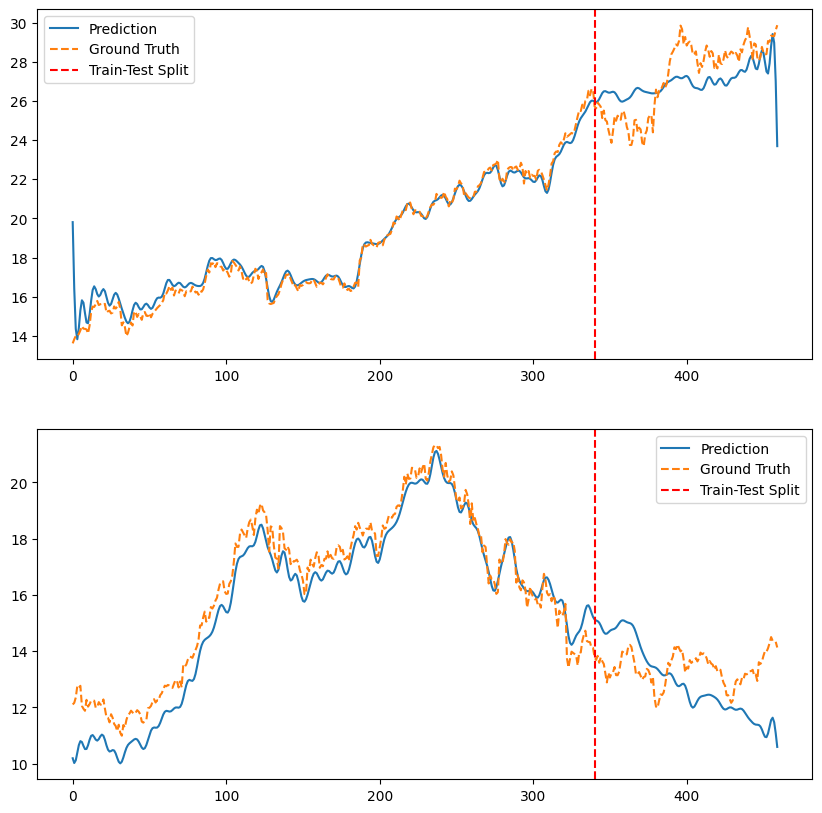

In [161]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(output[0,:,0], label="Prediction")
plt.plot(batch_xy[0,:,0],'--', label="Ground Truth")
plt.axvline(seq_len, color='r', linestyle='--', label="Train-Test Split")
plt.legend()
plt.subplot(2,1,2)
plt.plot(output[1,:,0], label="Prediction")
plt.plot(batch_xy[1,:,0], '--', label="Ground Truth")
plt.axvline(seq_len, color='r', linestyle='--', label="Train-Test Split")
plt.legend()
plt.show()